In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['CSE 5324 Iteration v1.1.gdoc',
 'linruanSop.gdoc',
 'final.csv',
 'linrandnewSop.gdoc',
 'Paper',
 'mnist_cnn.py',
 'dataset',
 'content',
 'ratings.csv',
 'ratings1.csv',
 'dm',
 'code_ipynb',
 'ngcf_model.pth.tar',
 'ngcf_model_loss.pth.tar',
 'ncf_ngcf.png',
 'se_final_test.gdoc',
 'ml_final_test.gdoc',
 'dm_final_test.gdoc',
 'Untitled0.ipynb',
 'dm_final',
 'DM_quiz.gdoc']

In [0]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import feature_extraction, linear_model, model_selection, preprocessing


## data preprocess

### for this part, we load our dataset, and then drop useless column, and we also drop contain miss value line, and we convert the uppercase letters to lowercase, and the below is shown the dataset we have processed, it contains the rating and comment column.

In [3]:
def preprocess(file_path):
    
    comment_rating = pd.read_csv(file_path, encoding = "ISO-8859-1")
    comment_rating = comment_rating.drop(columns=["Unnamed: 0", 'user', 'ID', 'name'])
    comment_rating = comment_rating.dropna(axis = 0, how = 'any')    
    comment_rating = comment_rating.reset_index(drop = True)
    comment_rating["comment"] = comment_rating["comment"].apply(lambda x: x.lower())
    
    return comment_rating

comment_rating = preprocess('/content/drive/My Drive/dm_final/boardgamegeek-reviews/bgg-13m-reviews.csv')   

comment_rating


,rating,comment
0,10.0,"currently, this sits on my list as my favorite..."
1,10.0,"i know it says how many plays, but many, many ..."
2,10.0,i will never tire of this game.. awesome
3,10.0,this is probably the best game i ever played. ...
4,10.0,fantastic game. got me hooked on games all ove...
...,...,...
2637751,3.0,horrible party game. i'm dumping this one!
2637752,3.0,difficult to build anything at all with the in...
2637753,3.0,"lego created a version of pictionary, only you..."
2637754,2.5,this game is very similar to creationary. it c...


### And then, we producing our rating part, let the rating number round to integer, it's benefit to the next part we predict the comment.

In [4]:
def generation_new_set(comment_rating):
    rating_num_set = {}
    for rating in range(1, 11, 1):
        new_comment_rating = comment_rating.loc[comment_rating['rating'] >= (rating - 0.5)]
        new_comment_rating = new_comment_rating.loc[new_comment_rating['rating'] <= (rating + 0.5)]
        new_comment_rating = new_comment_rating.sample(frac = 1).reset_index(drop = True)
        rating_num_set[rating] = new_comment_rating
    return rating_num_set

rating_num_set = generation_new_set(comment_rating)

for rating in rating_num_set:
    print("rating: ", rating, "rating num:",  len(rating_num_set[rating]))
    

rating:  1 rating num: 20960
rating:  2 rating num: 40766
rating:  3 rating num: 77967
rating:  4 rating num: 136565
rating:  5 rating num: 255791
rating:  6 rating num: 526481
rating:  7 rating num: 775531
rating:  8 rating num: 657581
rating:  9 rating num: 322400
rating:  10 rating num: 153530


### it's show the bar chat about the rating and the rating number. the rating of 6, 7, 8 contains most part.

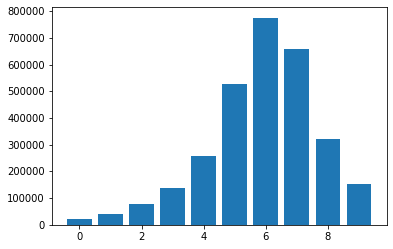

In [40]:
rating_list = []
for rating in rating_num_set: 
    rating_list.append(len(rating_num_set[rating]))
plt.bar(range(len(rating_list)), rating_list)
plt.show()


### split the data into trainset testset development set, and reset index.

In [0]:
def split_train_dev_test(comment_rating):
   
    train_set = comment_rating[:int(0.7 * len(comment_rating))]
    test = comment_rating[int(0.7 * len(comment_rating)):]
    test_set = test[:int(0.5 * len(test))]
    dev_set = test[int(0.5 * len(test)):]
    
    dev_set = dev_set.sample(frac = 1).reset_index(drop = True)
    test_set = test_set.sample(frac = 1).reset_index(drop = True)
    
    train_set = train_set.copy()
    train_set['reating'] = [round(rating) for rating in train_set['rating']]
    test_set['reating'] = [round(rating) for rating in test_set['rating']]
    dev_set['reating'] = [round(rating) for rating in dev_set['rating']]

    return train_set, test_set, dev_set

train_set, dev_set, test_set = split_train_dev_test(comment_rating)


In [7]:
print("length of train_set: ", len(train_set))
print("length of dev_set: ", len(dev_set))
print("length of test_set: ", len(test_set))


length of train_set:  1846429
length of dev_set:  395663
length of test_set:  395664


### we design two vectorizer function: tfidf and count, and use this function to process the train set and development set, to get the result for next prediction, and then compared the accuracy of the two vectorizer function handal the modul efficiency.

In [0]:
def vectorizer_tfidf(train_set, test_set, dev_set):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(train_set['comment'])
    
    train_tfidf = tfidf_model.transform(train_set['comment'])
    test_tfidf = tfidf_model.transform(test_set['comment'])
    dev_tfidf = tfidf_model.transform(dev_set['comment'])
    
    train_tag = train_set['reating'].astype(int)
    test_tag = test_set['reating'].astype(int)
    dev_tag = dev_set['reating'].astype(int)
    
    return train_tfidf, train_tag, test_tfidf, test_tag, dev_tfidf, dev_tag

train_tfidf, train_tag, test_tfidf, test_tag, dev_tfidf, dev_tag = vectorizer_tfidf(train_set, test_set, dev_set)


In [0]:
def vectorizer_count(train_set, test_set, dev_set):
    count_model = CountVectorizer()
    count_model.fit(train_set['comment'])
    
    train_count = count_model.transform(train_set['comment'])
    test_count = count_model.transform(test_set['comment'])
    dev_count = count_model.transform(dev_set['comment'])
    
    train_tag = train_set['reating'].astype(int)
    test_tag = test_set['reating'].astype(int)
    dev_tag = dev_set['reating'].astype(int)
    
    return train_count, train_tag, test_count, test_tag, dev_count, dev_tag

train_count, train_tag, test_count, test_tag, dev_count, dev_tag = vectorizer_count(train_set, test_set, dev_set)


## naive bayes modul.

### use naive bayes modul to train our dataset and predict the rating, the bayes theorem p(y|x1x2x3...xn) = p(x1x2x3...xn|y)p(y) / p(x1x2x3...xn). to get the predict, we useing two method to compared the prediction, and drow the bar graph to visualization.

In [0]:
accuracies = {}

In [11]:
def apply_tiidf_bayes(train_tfidf, train_tag, dev_tfidf, dev_tag):
    naive_bayes = MultinomialNB()
    naive_bayes.fit(train_tfidf, train_tag)
    dev_predict = naive_bayes.predict(dev_tfidf)
    accuracy = accuracy_score(dev_tag, dev_predict) * 100
    accuracies['tfidf_bayes'] = accuracy / 100
    print('tfidfvectorizer on naive bayes accuracy: ', accuracy)
    return accuracies

accuracies = apply_tiidf_bayes(train_tfidf, train_tag, dev_tfidf, dev_tag)


tfidfvectorizer on naive bayes accuracy:  24.813793556637844


In [41]:
def apply_tiidf_bayes(train_count, train_tag, dev_count, dev_tag):
    naive_bayes = MultinomialNB()
    naive_bayes.fit(train_count, train_tag)
    dev_predict = naive_bayes.predict(dev_count)
    accuracy = accuracy_score(dev_tag, dev_predict) * 100
    accuracies['count_bayes'] = accuracy / 100
    
    print('countvectorizer on naive bayes accuracy: ', accuracy)
    return accuracies, naive_bayes

accuracies, naive_bayes = apply_tiidf_bayes(train_count, train_tag, dev_tfidf, dev_tag)


countvectorizer on naive bayes accuracy:  26.034023904181087


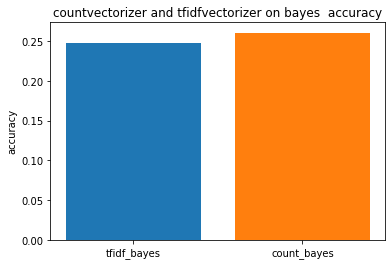

In [13]:
figure = plt.figure(figsize=(6, 4)).add_subplot()        
figure.set_title('countvectorizer and tfidfvectorizer on bayes  accuracy')
figure.set_xticklabels(['tfidf_bayes', 'count_bayes']) 
figure.set_ylabel('accuracy')
plt.bar('tfidf_bayes', accuracies['tfidf_bayes'])
figure = plt.bar('count_bayes', accuracies['count_bayes'])


## svm modul

### using svm to train our modul, the svm theorem: yi(w/||w||* xi + b / ||w||). and get the prediction, compared the two method, and get the best modul.

In [0]:
show_figure = {}

In [15]:
def apply_tiidf_svm(train_tfidf, train_tag, dev_tfidf, dev_tag):
    svm_modul = LinearSVC()
    svm_modul.fit(train_tfidf, train_tag)
    dev_predict = svm_modul.predict(dev_tfidf)
    accuracy = accuracy_score(dev_tag, dev_predict) * 100

    show_figure['tfidf_svm'] = accuracy / 100
    print('tfidfvectorizer on svm accuracy: ', accuracy)
    return show_figure

show_figure = apply_tiidf_svm(train_tfidf, train_tag, dev_tfidf, dev_tag)


tfidfvectorizer on svm accuracy:  29.629002459163477


In [18]:
def apply_count_bayes(train_count, train_tag, dev_count, dev_tag):
    svm_modul = LinearSVC()
    svm_modul.fit(train_count, train_tag)
    dev_predict = svm_modul.predict(dev_count)
    accuracy = accuracy_score(dev_tag, dev_predict) * 100
    show_figure['count_svm'] = accuracy / 100
    
    print('countvectorizer on svm accuracy: ', accuracy)
    return show_figure

show_figure = apply_count_bayes(train_tfidf, train_tag, dev_tfidf, dev_tag)


countvectorizer on svm accuracy:  32.770847872001305


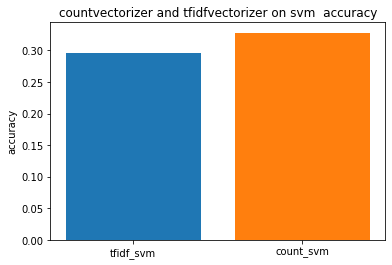

In [22]:
figure = plt.figure(figsize=(6, 4)).add_subplot()        
figure.set_title('countvectorizer and tfidfvectorizer on svm  accuracy')
figure.set_xticklabels(['tfidf_svm', 'count_svm']) 
figure.set_ylabel('accuracy')
plt.bar('tfidf_svm', show_figure['tfidf_svm'])
figure = plt.bar('count_svm', show_figure['count_svm'])


In [61]:
count_model = CountVectorizer()
count_model.fit(train_set['comment'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
while True:

    input_string = input()
    input_string_list = []

    input_string_list.append(input_string)
    input_string1 = count_model.transform(input_string_list)
    input_string_list.clear()

    get_predict = naive_bayes.predict(input_string1)
    print("rating is : ", get_predict)
